# Model averaging

In [1]:
using RxInfer, Distributions, Random, PyPlot

### Data generation

In [2]:
# specify distribution
dist = MixtureModel(Normal, [(-2.0, 1.0), (0.0, 1.0), (3.0, 1.0)], [0.2, 0.5, 0.3]);

In [3]:
function generate_data(dist, nr_samples; rng=MersenneTwister(123))

    # sample from distribution
    samples = rand(rng, dist, nr_samples)

    # return samples
    return samples

end;

In [4]:
data = generate_data(dist, 1000);

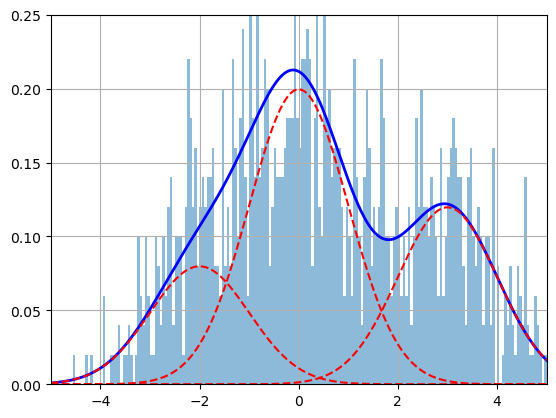

(0.0, 0.25)

In [5]:
plt.plot(-5:0.01:5, map(x -> pdf(dist, x), -5:0.01:5), color="blue", linewidth=2)
plt.hist(data, density="relative", bins=200, alpha=0.5)
plt.plot(-5:0.01:5, map(x -> dist.prior.p[1]*pdf(dist.components[1], x), -5:0.01:5), color="red", linestyle="--")
plt.plot(-5:0.01:5, map(x -> dist.prior.p[2]*pdf(dist.components[2], x), -5:0.01:5), color="red", linestyle="--")
plt.plot(-5:0.01:5, map(x -> dist.prior.p[3]*pdf(dist.components[3], x), -5:0.01:5), color="red", linestyle="--")
plt.grid()
plt.xlim(-5, 5)
plt.ylim(0, 0.25)

## Model specification

In [6]:
@model function model_averaging(nr_samples)

    # specify experimental outcomes
    y = datavar(Float64, nr_samples)
    θ = randomvar(nr_samples)
    z = randomvar(nr_samples)

    # specify John's and Jane's prior models over θ
    θ1 ~ NormalMeanPrecision(-5, 0.01)
    θ2 ~ NormalMeanPrecision(0, 0.01)
    θ3 ~ NormalMeanPrecision(5, 0.01)

    # create likelihood models
    for i in 1:nr_samples

        # specify initial guess as to who is right
        z[i] ~ Categorical([1/3, 1/3, 1/3])

        # specify mixture prior Distribution
        θ[i] ~ Switch(z[i], (θ1, θ2, θ3))

        # specify observatio noise
        y[i] ~ NormalMeanPrecision(θ[i], 1.0)
        
    end

    return y, θ, θ1, θ2, θ3, z

end

In [7]:
results_averaging = inference(
    model = model_averaging(1000), 
    data  = (y = data, ),
    returnvars = (θ = KeepLast(), θ1 = KeepLast(), θ2 = KeepLast(), θ3 = KeepLast(), z=KeepLast()),
    options = ( addons = (AddonLogScale(),), )
)

LoadError: UndefVarError: z not defined

In [ ]:
results_averaging.posteriors[:z]